# Actividad 2 - Clasificación
# Universidad Europea de Madrid
Inteligencia Artificial<br>
Isabel Sutil<br>
M31<br>
Jorge Javier Castilla Coello<br>
Geronimo Basso Sosa<br>
Luis Cabello Casquete<br>
Paula Sáenz de Santa María Diez<br>
Ana Esteban González<br>




# Codigo en común utilizado por todos los apartados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.base import clone
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer

# Apartado 0
Modificar el dataset para que cada vez que en "prec" se encuente el valor 0,0 se considere que no llueve, para los demas valores se va a considerar que si ha llovido

In [2]:
# Cargamos el fichero necesario para analizar el modelo.
ruta_archivo = 'valores-climatologicos.csv'
dataframe = pd.read_table(ruta_archivo, sep=',')

#Utilizando una función lambda, para cada valor de ´prec´cambiamos su valor a 0 si la precipitación es 0
#cambiamos el valor a 1 si la precipitación es disitnto de 0. Además, creamos un mapeo de indivaticos de provincia para tener valores de tipo int en esa columna envez de strings.
dataframe['prec'] = dataframe['prec'].apply(lambda x: 'YES' if x > 0 else 'NO')
states = ['1387E', '1387', '1393', '1351', '1400', '1437O', '1473A', '1428', '1475X', '1505', '1484', '1484C', '1495']
state_map = {state: idx for idx, state in enumerate(sorted(set(states)))}
dataframe['indicativo'] = dataframe['indicativo'].apply(lambda x: state_map[x])

# Crear un data set especifico con valores de tipo float para que los modelos puedan entrenar mejor.
# dataframe = dataframe.astype(float)
columns_to_convert = ['indicativo', 'altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'presMax', 'presMin']

# Converting each specified column to float
for column in columns_to_convert:
    dataframe[column] = dataframe[column].astype(float)

# Convertir la columna 'prec' de 'float' a 'categorical'
dataframe['prec'] = pd.Categorical(dataframe['prec'])
print(dataframe)

       indicativo  altitud  tmed prec  tmin  tmax   dir  velmedia  racha  \
0             2.0     98.0  16.9   NO  12.0  21.8   1.0       3.1    8.3   
1             2.0     98.0  20.5  YES  12.5  28.5  22.0       4.7   11.7   
2             2.0     98.0  21.4   NO  17.6  25.1  22.0       2.2   10.3   
3             2.0     98.0  21.4  YES  16.0  26.8  99.0       5.3   10.8   
4             2.0     98.0  18.6   NO  15.7  21.6   4.0       3.9   11.7   
...           ...      ...   ...  ...   ...   ...   ...       ...    ...   
11531        11.0    255.0  12.2   NO   5.5  18.8   8.0       1.7    9.7   
11532        11.0    255.0  11.2  YES   5.4  16.9  99.0       3.6    8.3   
11533        11.0    255.0   9.8  YES   6.4  13.1  27.0       1.7    7.2   
11534        11.0    255.0  11.7   NO   7.5  15.9  19.0       1.9    6.7   
11535        11.0    255.0  10.6  YES   8.7  12.6  20.0       5.0   13.9   

       presMax  presMin  
0       1008.7   1003.9  
1       1008.5   1005.5  
2       1

Utilizando una función lambda, para cada valor de ´prec´cambiamos su valor a 0 si la precipitación es 0
cambiamos el valor a 1 si la precipitación es disitnto de 0. Además, creamos un mapeo de indivaticos de provincia para tener valores de tipo int en esa columna envez de strings.

# Crear el dataset de entrenamieno y validación, y además crear el cross validation.

In [3]:
X = dataframe.drop('prec', axis=1)  # Features
y = dataframe['prec']  # Variable de salida

# División en 80/20 para entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))

# Crear conjuntos de entrenamiento y prueba
conjunto_train = pd.concat([X_train, y_train], axis=1)
conjunto_val = pd.concat([X_val, y_val], axis=1)

# Creamos dos conjuntos para poner las predicciones del train y test
conjunto_train_eval = conjunto_train.copy()
conjunto_validation_eval = conjunto_val.copy()

# Método de control (k-fold cross-validation)
metodo_control_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Tamaño del conjunto de entrenamiento: 9228
Tamaño del conjunto de validación: 2308


# Apartado 3
Análisis predictivo con KNN

Entrenamos nuestro modelo con un tuneLength de 10

In [4]:
precision_train = {}
precision_val = {}

# Definir los parámetros que deseas ajustar
param_grid = {'kneighborsclassifier__n_neighbors': list(range(1, 11))}

# Establecer la semilla para reproducibilidad
np.random.seed(150)

In [5]:
# Definir el modelo KNN
knn_model = KNeighborsClassifier()

pipeline = make_pipeline(StandardScaler(), knn_model)

# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(accuracy_score), cv=metodo_control_cv)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Imprimir resultados
print("Mejor modelo:", best_model)

y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

print("Precisión en el conjunto de entrenamiento:", accuracy_train)

precision_train['knn_tuneLength_10'] = accuracy_train

# Obtener los resultados del grid search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Imprimir información sobre el proceso de búsqueda
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search.best_score_)

# Imprimir resultados de cada conjunto de parámetros
print(resultados_df[['params', 'mean_test_score']])

Mejor modelo: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=9))])
Precisión en el conjunto de entrenamiento: 0.8201127004768097
Mejores parámetros: {'kneighborsclassifier__n_neighbors': 9}
Mejor puntuación de validación cruzada (Accuracy): 0.7801237594094518
                                      params  mean_test_score
0   {'kneighborsclassifier__n_neighbors': 1}         0.735259
1   {'kneighborsclassifier__n_neighbors': 2}         0.725943
2   {'kneighborsclassifier__n_neighbors': 3}         0.764844
3   {'kneighborsclassifier__n_neighbors': 4}         0.761053
4   {'kneighborsclassifier__n_neighbors': 5}         0.772864
5   {'kneighborsclassifier__n_neighbors': 6}         0.771022
6   {'kneighborsclassifier__n_neighbors': 7}         0.778824
7   {'kneighborsclassifier__n_neighbors': 8}         0.779582
8   {'kneighborsclassifier__n_neighbors': 9}         0.780124
9  {'kneighborsclassifier__n_neighbors'

In [6]:
# Crear un pipeline con escalado y clasificador KNN
model = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Lista para almacenar las puntuaciones de accuracy en cada fold y para cada conjunto de parámetros
accuracy_scores = []

# Realizar la validación cruzada
for fold, (train_idx, val_idx) in enumerate(metodo_control_cv.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    print(f"\nFold {fold + 1}:")

    for params in param_grid.values():
        for param_value in params:
            # Crear un modelo con el valor actual del parámetro
            model.set_params(kneighborsclassifier__n_neighbors=param_value)

            # Entrenar el modelo
            model.fit(X_train_fold, y_train_fold)

            # Evaluar el modelo en el conjunto de validación
            accuracy = model.score(X_val_fold, y_val_fold)

            # Imprimir la puntuación de accuracy para el valor actual del parámetro
            print(f"   {list(param_grid.keys())[0]}={param_value}, Accuracy={accuracy}")

            # Almacenar la puntuación de accuracy
            accuracy_scores.append({'Fold': fold + 1, list(param_grid.keys())[0]: param_value, 'Accuracy': accuracy})




Fold 1:
   kneighborsclassifier__n_neighbors=1, Accuracy=0.7400346620450606
   kneighborsclassifier__n_neighbors=2, Accuracy=0.7417677642980935
   kneighborsclassifier__n_neighbors=3, Accuracy=0.7729636048526863
   kneighborsclassifier__n_neighbors=4, Accuracy=0.7746967071057193
   kneighborsclassifier__n_neighbors=5, Accuracy=0.7859618717504333
   kneighborsclassifier__n_neighbors=6, Accuracy=0.7790294627383015
   kneighborsclassifier__n_neighbors=7, Accuracy=0.7807625649913345
   kneighborsclassifier__n_neighbors=8, Accuracy=0.7781629116117851
   kneighborsclassifier__n_neighbors=9, Accuracy=0.7781629116117851
   kneighborsclassifier__n_neighbors=10, Accuracy=0.7833622183708839

Fold 2:
   kneighborsclassifier__n_neighbors=1, Accuracy=0.755632582322357
   kneighborsclassifier__n_neighbors=2, Accuracy=0.7530329289428076
   kneighborsclassifier__n_neighbors=3, Accuracy=0.7920277296360485
   kneighborsclassifier__n_neighbors=4, Accuracy=0.7920277296360485
   kneighborsclassifier__n_nei

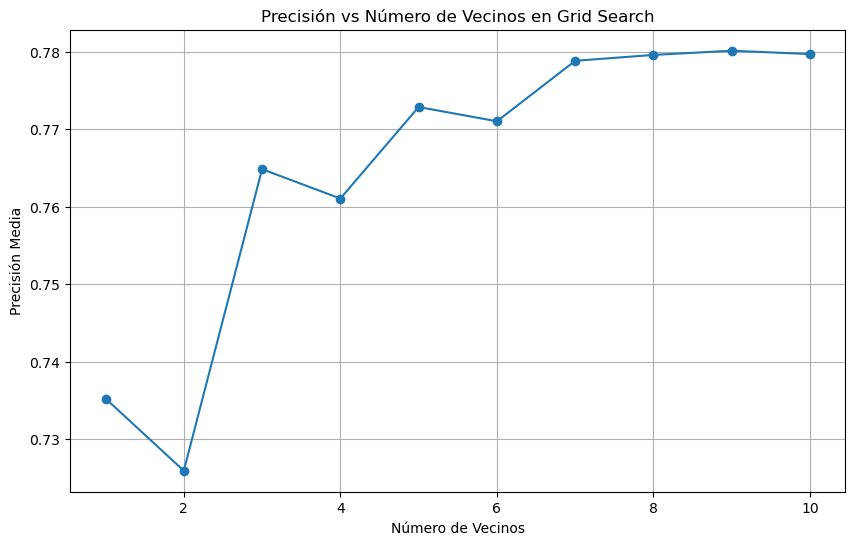

In [7]:
# Extraer los resultados del Grid Search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Obtener los valores relevantes
parametros = resultados_df['param_kneighborsclassifier__n_neighbors']
precision_media = resultados_df['mean_test_score']

# Graficar la precisión en función del número de vecinos
plt.figure(figsize=(10, 6))
plt.plot(parametros, precision_media, marker='o')
plt.title('Precisión vs Número de Vecinos en Grid Search')
plt.xlabel('Número de Vecinos')
plt.ylabel('Precisión Media')
plt.grid(True)
plt.show()

In [8]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)

print("Precisión en el conjunto de validación:", accuracy)
precision_val['knn_tuneLength_10'] = accuracy## Validacion con un tuneLength 10

Precisión en el conjunto de validación: 0.7803292894280762


In [9]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)

print("Precisión en el conjunto de validación:", accuracy)
precision_val['knn_tuneLength_10'] = accuracy

Precisión en el conjunto de validación: 0.7803292894280762
